In [1]:
import numpy as np
print("Numpy version: "+np.__version__)
from sklearn import __version__ as skver
print("Scikit-learn version: "+skver)
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pylab as plt
print("Matplotlib version: "+plt.__version__)

Numpy version: 1.13.0
Scikit-learn version: 0.19.0
Matplotlib version: 1.13.0


### Generate data for the XOR classification problem

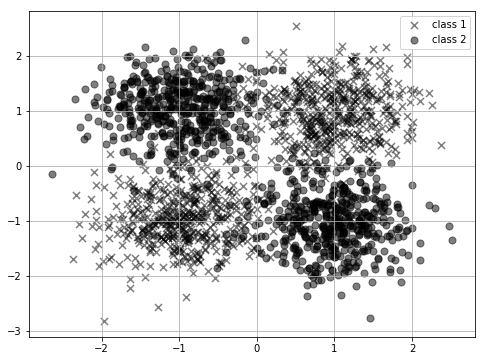

In [2]:
N = 2000  # number of samples
X, Y = make_blobs(n_samples=N, centers=[[1, 1], [-1, 1], [1, -1], [-1, -1]], cluster_std=0.5)
# Make it a two-class problem:
Y[Y==2] = 1.0
Y[Y==3] = 0.0 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='k', marker='x', 
           s=50, alpha=0.5, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='k', marker='o', 
           s=50, alpha=0.5, label='class 2')
plt.legend()
plt.grid()

In [3]:
# Simple train, test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.25, test_size=0.75)
# Create meshgrid for the probability plots
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

## Multilayer perceptron (MLP), pure-Numpy implementation

- Mean-square error cost function
- Output layer with one neuron (two classes) and sigmoid activation function
- Single hidden layer with tanh activation function

**Proposed:** Code the cross-entropy cost function. Does it train faster than MSE? Is accuracy improved?

In [4]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

class Layer:
    def __init__(self, N_input, N_neurons, activation="tanh"):        
        self.N_input = N_input
        self.N_neurons = N_neurons
        self.activation = activation
        self.W = np.zeros(shape=(N_input, N_neurons)) # weights
        self.b = np.zeros(shape=(N_neurons, )) # bias
        self.initialize_parameters()  
        self.z = np.zeros(shape=(N_neurons)) # z = Wx + b
        self.y = np.zeros(shape=(N_neurons)) # y = sgm(z)
        
    def initialize_parameters(self):
        if self.activation == "tanh":
            self.W = np.array(np.random.uniform(low=-np.sqrt(6.0/(self.N_input + self.N_neurons)),
                                                high=np.sqrt(6.0/(self.N_input + self.N_neurons)),
                                                size=(self.N_input, self.N_neurons)))
        else: 
            self.W = np.array(np.zeros(shape=(self.N_input, self.N_neurons)))
        self.b = np.zeros(shape=(self.N_neurons, ))
        
    def output(self, x):  #  x is an array N_input x 1
        self.z = np.dot(x, self.W) + self.b
        if self.activation == "tanh":
            self.y = np.tanh(self.z)
        elif self.activation == "sigmoid":
            self.y = sigmoid(self.z)
        return self.y
    
class MLP:
    def __init__(self, N_input, N_hidden):
        self.layers = []
        self.N_output = 1
        self.output_activation = "sigmoid"
        if N_hidden > 0:
            self.layers.append(Layer(N_input, N_hidden)) #  hidden layers use tanh activation
            self.layers.append(Layer(N_hidden, self.N_output, activation="sigmoid"))
        else:
            self.layers.append(Layer(N_input, self.N_output, activation="sigmoid"))
            
    def predict_proba(self, x):
        for layer in self.layers:
            x = layer.output(x)
        return x
        
    def predict(self, x):
        x = self.predict_proba(x)
        if self.output_activation is "sigmoid":
            return x > 0.5
        elif self.output_activation is "tanh":
            return x > 0.0
        
    def reset(self):
        for layer in self.layers:
            layer.initialize_parameters()
    
    def mse(self, x, y):
        e = self.predict_proba(x)[:,0] - y
        return np.mean(np.power(e, 2.0))

In [5]:
class Trainer:
    def __init__(self, classifier, learning_rate=1.0, max_epoch=1000):
        self.classifier = classifier
        self.lr = learning_rate
        self.train_cost = np.zeros(shape=(max_epoch,))
        self.test_cost = np.zeros(shape=(max_epoch, ))   
        self.max_epoch = max_epoch
        self.current_epoch = 0

    def update(self, data_train, label_train, data_test, label_test, batch_size=32):
        if self.current_epoch == 0:  
            self.train_cost[0] =  self.classifier.mse(data_train, label_train) 
            self.test_cost[0] =  self.classifier.mse(data_test, label_test) 
        # Present mini-batches in different order each epoch
        else:        
            rand_perm = np.random.permutation(len(label_train))
            data_train = data_train[rand_perm, :].copy()
            label_train = label_train[rand_perm].copy()
            self.minibach_eval(data_train, label_train, batch_size)
            self.train_cost[self.current_epoch] = self.classifier.mse(data_train, label_train) 
            self.test_cost[self.current_epoch] =  self.classifier.mse(data_test, label_test)               
        self.current_epoch += 1
    
    def reset(self):
        self.classifier.reset()        

    def minibach_eval(self, data, labels, batch_size=32):
        averaged_cost = 0.0
        N = len(labels)
        for Nbatches, (start, end) in enumerate(zip(range(0, N, batch_size), range(batch_size, N+1, batch_size))):
            self.train(data[start:end], labels[start:end])
        #return averaged_cost/Nbatches
    
    def train(self, data, labels):
        N = len(labels)
        error = (self.classifier.predict_proba(data)[:, 0] - labels)[:, np.newaxis]
        Nlayer = len(self.classifier.layers)
        # This considers an outer layer with one neuron
        layer_idx = Nlayer-1 
        out_layer = self.classifier.layers[layer_idx]
        tmp = np.multiply(error, sigmoid(out_layer.z)*(1.0-sigmoid(out_layer.z)))
        grad_b = np.mean(tmp, axis=0)
        if Nlayer == 1:
            grad_w = np.mean(np.multiply(np.tile(tmp, (1, out_layer.N_input)), data), axis=0)
        else:
            hidden_layer = self.classifier.layers[layer_idx-1]
            grad_w = np.mean(np.multiply(np.tile(tmp, (1, out_layer.N_input)), hidden_layer.y), axis=0) 
        # gradient descent
        self.classifier.layers[layer_idx].W -= self.lr*grad_w[:, np.newaxis]
        self.classifier.layers[layer_idx].b -= self.lr*grad_b
        # Train the hidden layer
        if Nlayer > 1:
            Nh = out_layer.N_input
            E = np.tile(error*sigmoid(out_layer.z)*(1.0-sigmoid(out_layer.z)), (1, Nh))
            tmp = np.multiply(np.multiply(E, 1.0-np.tanh(hidden_layer.z)**2), np.tile(out_layer.W.T, (N, 1)))
            grad_b = np.mean(tmp, axis=0)
            grad_w = np.dot(tmp.T, data).T
            # gradient descent
            self.classifier.layers[layer_idx-1].W -= self.lr*grad_w
            self.classifier.layers[layer_idx-1].b -= self.lr*grad_b

## Training epoch by epoch

- Try changing the number of neurons in the hidden layer
- Try changing the learning rate
- Try changing mini-batch size

In [6]:
classifier = MLP(N_input=X.shape[1], N_hidden=5)
trainer = Trainer(classifier, learning_rate=0.5, max_epoch=1000)


Run the next block several times by hitting CTRL+ENTER. Plots are updated epoch by epoch

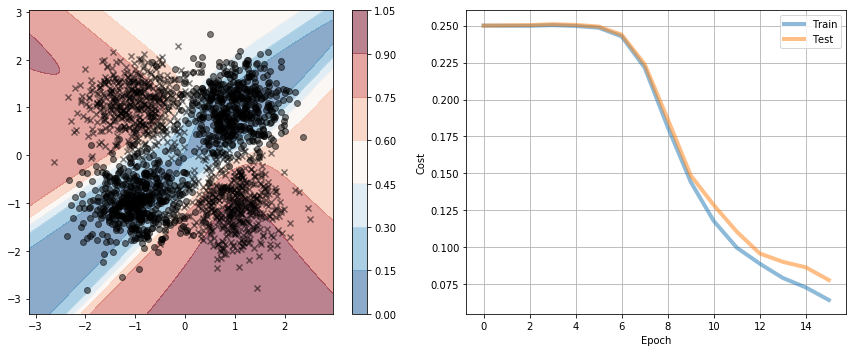

In [22]:
trainer.update(X_train, Y_train, X_test, Y_test, batch_size=10)
pred_labels = classifier.predict(X_test)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
cf = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu_r, alpha=0.5, vmin=0.0, vmax=1.0)
plt.colorbar(cf)
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='k', marker='x', alpha=0.5)

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.arange(0, trainer.current_epoch, step=1), 
        trainer.train_cost[:trainer.current_epoch], linewidth=4, alpha=0.5, label="Train")
ax.plot(np.arange(0, trainer.current_epoch, step=1), 
        trainer.test_cost[:trainer.current_epoch], linewidth=4, alpha=0.5, label="Test")
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
plt.legend()
plt.grid()
plt.tight_layout()

## Multilayer perceptron (MLP), tensorflow implementation

- Cross-entropy error cost function
- Output layer with one neuron (two classes) and sigmoid activation function
- Single hidden layer with tanh activation function
- ADAM learning rate
- Batch-mode

**Proposed:** Could you modify the code to do mini-batch instead?

In [23]:
import tensorflow as tf
print("Tensorflow version: "+tf.__version__)

Tensorflow version: 1.3.0


In [24]:
Nh = 5 # Hidden layer neurons
# Building the network
X_holder = tf.placeholder(tf.float32, [None, 2])
T_holder = tf.placeholder(tf.float32, [None, 1])
b_z = tf.Variable(tf.zeros([Nh]), name="z_b", dtype=tf.float32)
W_z = tf.Variable(tf.random_uniform([2, Nh], -1.0, 1.0), name="z_w", dtype=tf.float32)
z = tf.tanh(tf.matmul(X_holder, W_z) + b_z)
b_y = tf.Variable(tf.zeros([1]), name="y_b", dtype=tf.float32)
W_y = tf.Variable(tf.random_uniform([Nh, 1], -1.0, 1.0), name="y_w", dtype=tf.float32)
y = tf.add(tf.matmul(z, W_y), b_y)
# Cost function and optimization function
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=T_holder, logits=y)
loss = tf.reduce_mean(cross_entropy)  
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
train = optimizer.minimize(loss) 
init = tf.global_variables_initializer()

In [25]:
# Creating the tensorflow session
sess = tf.InteractiveSession()
sess.run(init)  
# Training procedure
max_epoch = 500 # Number of epochs
train_loss = np.zeros(shape=(max_epoch))
test_loss = np.zeros(shape=(max_epoch))
for i, epoch in enumerate(range(0, max_epoch)):
    # Train set evaluation and update
    _, train_loss[i] = sess.run([train, loss], feed_dict={X_holder: X_train, 
                                                          T_holder: np.reshape(Y_train, [-1, 1])})
    # Test set evaluation
    test_loss[i] = sess.run(loss, feed_dict={X_holder: X_test, 
                                             T_holder: np.reshape(Y_test, [-1, 1])})
Z = sess.run(tf.sigmoid(y), feed_dict={X_holder: np.c_[xx.ravel(), yy.ravel()].astype('float32')})
sess.close()

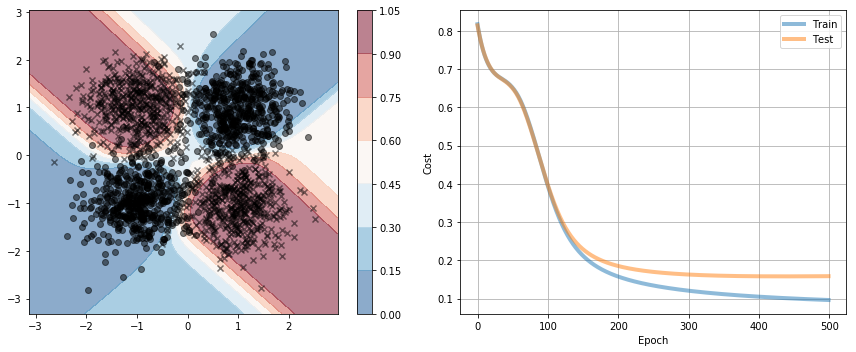

In [26]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 2)
plt.plot(train_loss, linewidth=4, alpha=0.5, label='Train')
plt.plot(test_loss, linewidth=4, alpha=0.5,  label='Test')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.legend()
ax = fig.add_subplot(1, 2, 1)
Z = Z.reshape(xx.shape)
cf = ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=0.5, vmin=0.0, vmax=1.0)
plt.colorbar(cf)
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='k', marker='x', alpha=0.5)
plt.tight_layout()

## Bayesian Multilayer perceptron (MLP), PyMC3 + theano implementation

- Gaussian prior on weights and biases
- Output layer with one neuron (two classes) and sigmoid activation function
- Single hidden layer with tanh activation function
- Bernoulli distribution for the output
- Batch-mode
- Training with Automatic Differentiation Variational Inference

Reference: http://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

In [27]:
import pymc3 as pm
import theano
floatX = theano.config.floatX
import theano.tensor as tt
print("Theano version: "+theano.__version__)
print("Pymc3 version: "+pm.__version__)

Theano version: 0.9.0.dev-89aac420cb6cc64328e23ee5dbe33c280b1eb980
Pymc3 version: 3.1rc3


In [28]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
# Create network (priors + posteriors)
with pm.Model() as neural_network:
    W_z = pm.Normal('wz', 0, sd=1, shape=(X.shape[1], Nh),
                    testval=np.random.randn(X.shape[1], Nh).astype(floatX))
    b_z = pm.Normal('bz', 0, sd=1, shape=(Nh,), testval=np.random.randn(Nh).astype(floatX))
    W_y = pm.Normal('wy', 0, sd=1, shape=(Nh,), 
                    testval=np.random.randn(Nh).astype(floatX))
    b_y = pm.Normal('by', 0, sd=1, shape=(1,), testval=np.random.randn(1).astype(floatX))
    z = pm.math.tanh(pm.math.dot(ann_input, W_z) + b_z)
    y = pm.math.sigmoid(pm.math.dot(z, W_y) + b_y)
    y_rv = pm.Bernoulli('y', y, observed=ann_output)

Average Loss = 140.57: 100%|██████████| 30000/30000 [00:09<00:00, 3050.74it/s]
Finished [100%]: Average Loss = 140.58


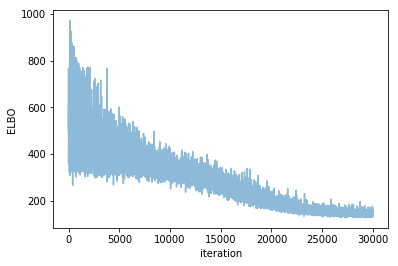

In [29]:
with neural_network:
    # Run ADVI to train
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)
    # Create a theano function to evaluate new samples
    x = tt.matrix('X')
    n = tt.iscalar('n')
    x.tag.test_value = np.empty_like(X_test)
    n.tag.test_value = 100
    _sample_proba = approx.sample_node(y_rv.distribution.p, size=n,
                                       more_replacements={ann_input: x})
    sample_proba = theano.function([x, n], _sample_proba)
    
# Output space prediction
pred = sample_proba(X_test, 500).mean(0) > 0.5
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)
# Evidence lower bound evolution
plt.plot(inference.hist, alpha=.5)
plt.ylabel('ELBO')
plt.xlabel('iteration')

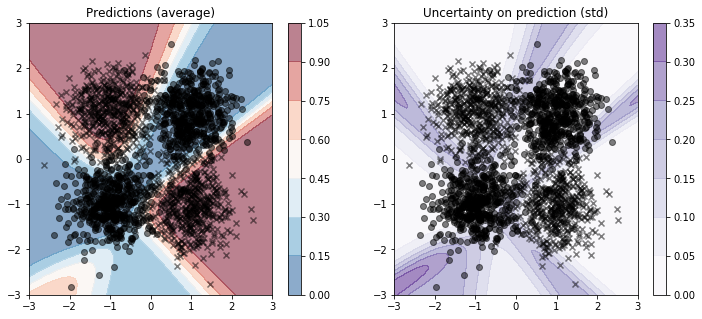

In [30]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
cf = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), 
                 vmin=0.0, vmax=1.0, cmap=plt.cm.RdBu_r, alpha=0.5)
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='k', marker='x', alpha=0.5)
plt.colorbar(cf)
plt.title('Predictions (average)')
ax = fig.add_subplot(1, 2, 2)
cf = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), 
                 cmap=plt.cm.Purples, alpha=0.5)
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='k', marker='x', alpha=0.5)
plt.colorbar(cf)
plt.title('Uncertainty on prediction (std)')